Import packages

In [22]:
import pandas as pd
import numpy as np
import os
from IPython import display

Scheme of ETL process

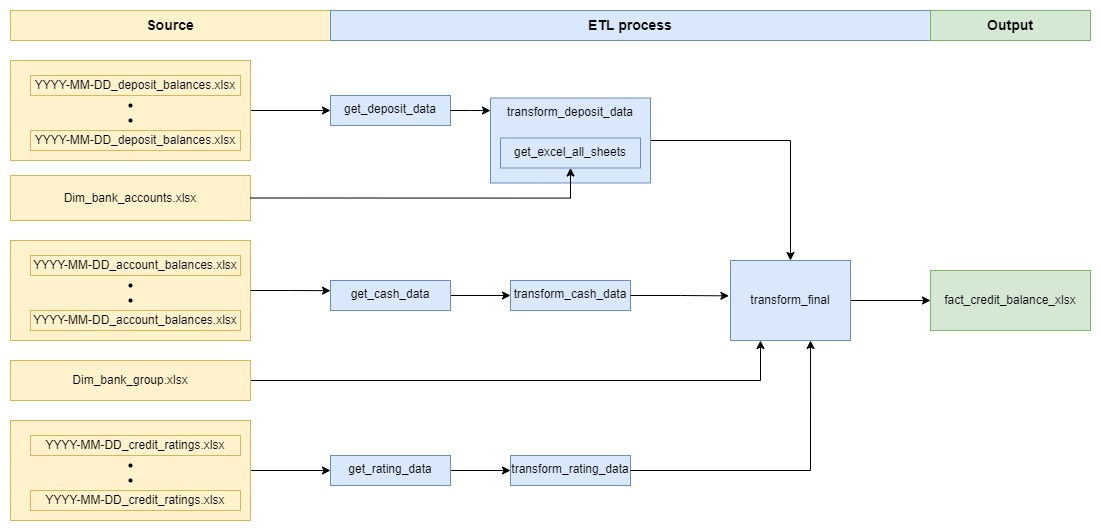

In [45]:
display.Image("etl_scheme_credit_risk.jpg", height=600, width=1200)

1. Parameters

2. Data blocks

2.1. Deposits

In [24]:
def get_deposit_data(path_folder: str) -> pd.DataFrame:

    depo_files_list = os.listdir(path_folder)

    depo_container = []
    for file in depo_files_list:
        df_depo_temp = pd.read_csv(f'{folder_path_deposit}/{file}', sep=';', dtype = str)
        df_depo_temp = df_depo_temp[['date_reporting', 'counterparty_code', 'product_type_short', 'closing_balance_eur']]
        depo_container.append(df_depo_temp)
    df_depo = pd.concat(depo_container)

    return df_depo

In [25]:
df_depo = get_deposit_data(path_folder=folder_path_deposit)

Import Dim_bank_accounts

In [26]:
def get_excel_all_sheets(path: str) -> pd.DataFrame:

    excel_file = pd.ExcelFile(path)
    df = []
    for sheet in excel_file.sheet_names:
        columns = excel_file.parse(sheet_name=sheet).columns
        converters = {column: str for column in columns}
        df_part = excel_file.parse(sheet_name=sheet, converters=converters)
        df.append(df_part)
    df = pd.concat(df, ignore_index=True)

    return df

In [27]:
def transform_deposit_data(df: pd.DataFrame, file_path_bank_accounts: str) -> pd.DataFrame:

    df_depo = df.loc[df['product_type_short'] != 'LOE'].reset_index(drop=True)
    df_depo['product_type_short'] = 'deposit'

    dim_bank_account = get_excel_all_sheets(path=file_path_bank_accounts)

    df_depo = pd.merge(df_depo, dim_bank_account[['account_number', 'account_description']], 
                   left_on='counterparty_code', right_on='account_number',
                   how='left')
    df_depo = df_depo[['date_reporting', 'account_description', 'product_type_short', 'closing_balance_eur']]

    return df_depo

In [28]:
df_depo = transform_deposit_data(df=df_depo, file_path_bank_accounts=file_dim_bank_account)

2.2. Cash

In [29]:
def get_cash_data(path_folder: str) -> pd.DataFrame:

    cash_files_list = os.listdir(path_folder)

    cash_container = []
    for file in cash_files_list:
        df_cash_temp = pd.read_csv(f'{folder_path_cash}/{file}', sep=';', dtype = str)
        df_cash_temp = df_cash_temp[['date_reporting', 'account_description', 'closing_balance_eur']]
        cash_container.append(df_cash_temp)
    df_cash = pd.concat(cash_container)

    return df_cash

In [30]:
df_cash = get_cash_data(path_folder=folder_path_cash)

In [31]:
def transform_cash_data(df: pd.DataFrame) -> pd.DataFrame:

    cn_cash_to_depo = ['xxx', 'yyy']
    df['product_type_short'] = np.where(df['account_description'].isin(cn_cash_to_depo), 'deposit', 'cash')
    df = df[['date_reporting', 'account_description', 'product_type_short', 'closing_balance_eur']]
    
    return df_cash

In [32]:
df_cash = transform_cash_data(df=df_cash)

2.3. Combine cash & deposit

Import Dim_bank_group

In [33]:
dim_bank_group = pd.read_excel(file_dim_bank_group, dtype=str)

Import ratings

In [34]:
def get_rating_data(path_folder: str) -> pd.DataFrame:

    rating_files_list = os.listdir(path_folder)

    rating_container = []
    for file in rating_files_list:
        df_rating_temp = pd.read_excel(f'{folder_path_rating}/{file}', dtype = str)
        df_rating_temp = df_rating_temp[['Date', 'PermID', 'SP Rating', 'Moody Rating', 'Fitch Rating']]
        rating_container.append(df_rating_temp)
    df_rating = pd.concat(rating_container)

    return df_rating

In [35]:
df_rating = get_rating_data(path_folder=folder_path_rating)

In [36]:
def transform_rating_data(df: pd.DataFrame) -> pd.DataFrame:

    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    df['date'] = pd.to_datetime(df['date'])
    df['date_yearno'] = df['date'].dt.isocalendar().year
    df['date_weekno'] = df['date'].dt.isocalendar().week
    df = df[['date', 'sp_rating', 'moody_rating', 'fitch_rating', 'date_yearno', 'date_weekno', 'permid']]

    return df

In [37]:
df_rating = transform_rating_data(df_rating)

In [38]:
def transform_final(df_cash: pd.DataFrame, df_depo: pd.DataFrame, df_rating: pd.DataFrame, file_path_bank_accounts: str) -> pd.DataFrame:

    df = pd.concat([df_cash, df_depo], ignore_index=True)
    df['closing_balance_eur'] = df['closing_balance_eur'].str.replace(',', '.').astype(float)
    df = pd.pivot_table(df, index=['date_reporting', 'account_description'], columns='product_type_short', values='closing_balance_eur', aggfunc='sum')
    df = df.rename_axis(None, axis=1).reset_index()
    df['date_reporting'] = pd.to_datetime(df['date_reporting'], format='%d.%m.%Y')
    df = df.sort_values(by=['date_reporting', 'account_description'])

    dim_bank_account = get_excel_all_sheets(path=file_path_bank_accounts)

    df = pd.merge(
    pd.merge(df, dim_bank_account[['account_description', 'id_bank_region']], on='account_description', how='left'),
    dim_bank_group[['id_bank_region', 'perm_id']], on='id_bank_region', how='left'
        ).drop(['id_bank_region'], axis=1)

    df[['date_match']] = df[['date_reporting']] - pd.Timedelta(days=4)
    df['date_match_weekno'] = df['date_match'].dt.isocalendar().week
    df['date_match_yearno'] = df['date_match'].dt.isocalendar().year
    df = df[['date_reporting', 'account_description', 'cash', 'deposit', 'date_match', 'date_match_yearno', 'date_match_weekno', 'perm_id']]

    df = pd.merge(df, df_rating, how='left', 
                left_on=['date_match_yearno', 'date_match_weekno', 'perm_id'], 
                right_on=['date_yearno', 'date_weekno', 'permid'])
    df = df[['date_reporting', 'account_description', 'cash', 'deposit', 'sp_rating', 'moody_rating', 'fitch_rating']]

    return df

In [39]:
df = transform_final(df_cash=df_cash, df_depo=df_depo, df_rating=df_rating, file_path_bank_accounts=file_dim_bank_account)

In [40]:
df.to_excel(f'{export_path}/fact_credit_balance.xlsx', index=False, sheet_name='fact_table')